In [1]:
import concurrent
import sys
import math
# import pandana as pdna
import quilt3
import os
import pandana as pdna
from geosnap import Community
from segregation.spatial import compute_segregation_profile
%matplotlib inline

Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 9023.89entries/s]
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.spectral module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 2205.98entries/s]


In [2]:
if not os.path.exists("../data/12580.h5"):
    p = quilt3.Package.browse('osm/metro_networks_8k', 's3://spatial-ucr')
    p['12580.h5'].fetch("../data/")

In [3]:
balt = Community.from_lodes(msa_fips='12580', years=list(range(2010, 2018,1)))

Loading manifest: 100%|██████████| 52/52 [00:00<00:00, 27583.64entries/s]
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
gdf = balt.gdf

In [5]:
gdf.year.unique()

array([2016, 2017, 2010, 2011, 2012, 2013, 2014, 2015])

In [6]:
net = pdna.Network.from_hdf5("../data/12580.h5")

In [7]:
net.precompute(3000)

Here we're doing a KNN to get the intersection node nearest to each block centroid

In [8]:
gdf["node_ids"] = net.get_node_ids(gdf.centroid.x,
                                   gdf.centroid.y)

In [9]:
centers = gdf.copy()

Taking each year as a dataset, loop over the network and calculate a 2.5km access kernel for each year

In [10]:
accs = []
for year in gdf.year.unique():

    tgdf = gdf.copy()
    tgdf = tgdf[tgdf.year==year]
    
    net.set(tgdf.node_ids, variable=tgdf["total_employees"], name="total_employees")

    access = net.aggregate(2500, type="sum", name="total_employees")
    access.name = year
    accs.append(access)


In [11]:
import pandas as pd
accs = pd.concat(accs, axis=1)


Combine them as a single dataframe where rows are node-level jobs accessible within 2500m walk and columns are the different years

In [12]:
accs.head()

,2016,2017,2010,2011,2012,2013,2014,2015
id,,,,,,,,
234661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now lets visualize them as groups of contiguous census tracts

In [13]:
tracts = Community.from_census(msa_fips='12580', years=[2010])

/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
tracts = tracts.gdf

In [15]:
tracts["node_ids"] = net.get_node_ids(tracts.centroid.x, tracts.centroid.y)

In [16]:
tracts = tracts.merge(accs, left_on='node_ids', right_index=True)

In [17]:
tracts = tracts.rename(str, axis='columns')

In [18]:
tracts['2010']

6        8994.310002
7           0.000000
8       43341.016656
9       27726.938648
10      25047.714050
            ...     
1388      584.856672
1389     1072.038472
1390     1270.960123
1392     1419.399765
1393     1442.956365
Name: 2010, Length: 680, dtype: float64

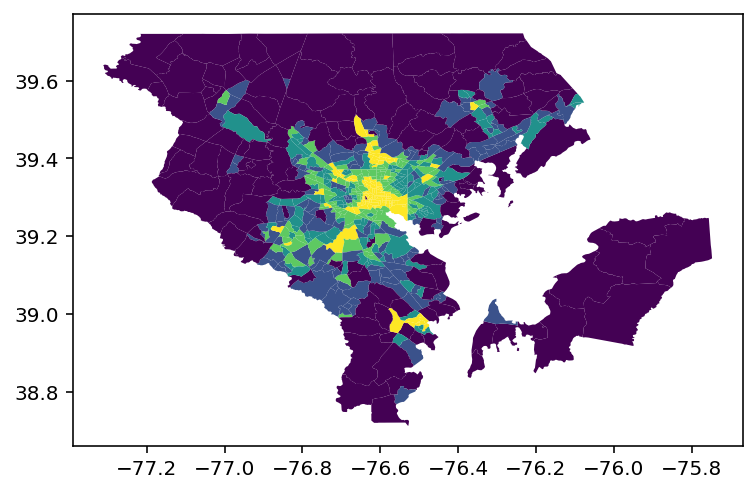

In [19]:
tracts.plot('2015', scheme="quantiles", k=5)

In [20]:
centers = tracts[tracts['2017'] >=8000]

In [21]:
import matplotlib.pyplot as plt

In [22]:
from libpysal.weights import Queen

This function wll take the raw data and return employment centers identified by some specified total employment threshold

In [23]:
def to_center(tracts, year, thresh):
    
    tracts = tracts.copy()
    centers = tracts[tracts[year] >=thresh]
    w = Queen.from_dataframe(centers)
    centers['labels'] = w.component_labels
    centers=centers.dissolve(aggfunc='sum', by='labels')
    
    return centers


Lets plot centers for each year and look at how they differ if we choose a different total employment threshold

/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 33, 34, 56, 63.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 32, 33, 52, 60.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/ipykerne

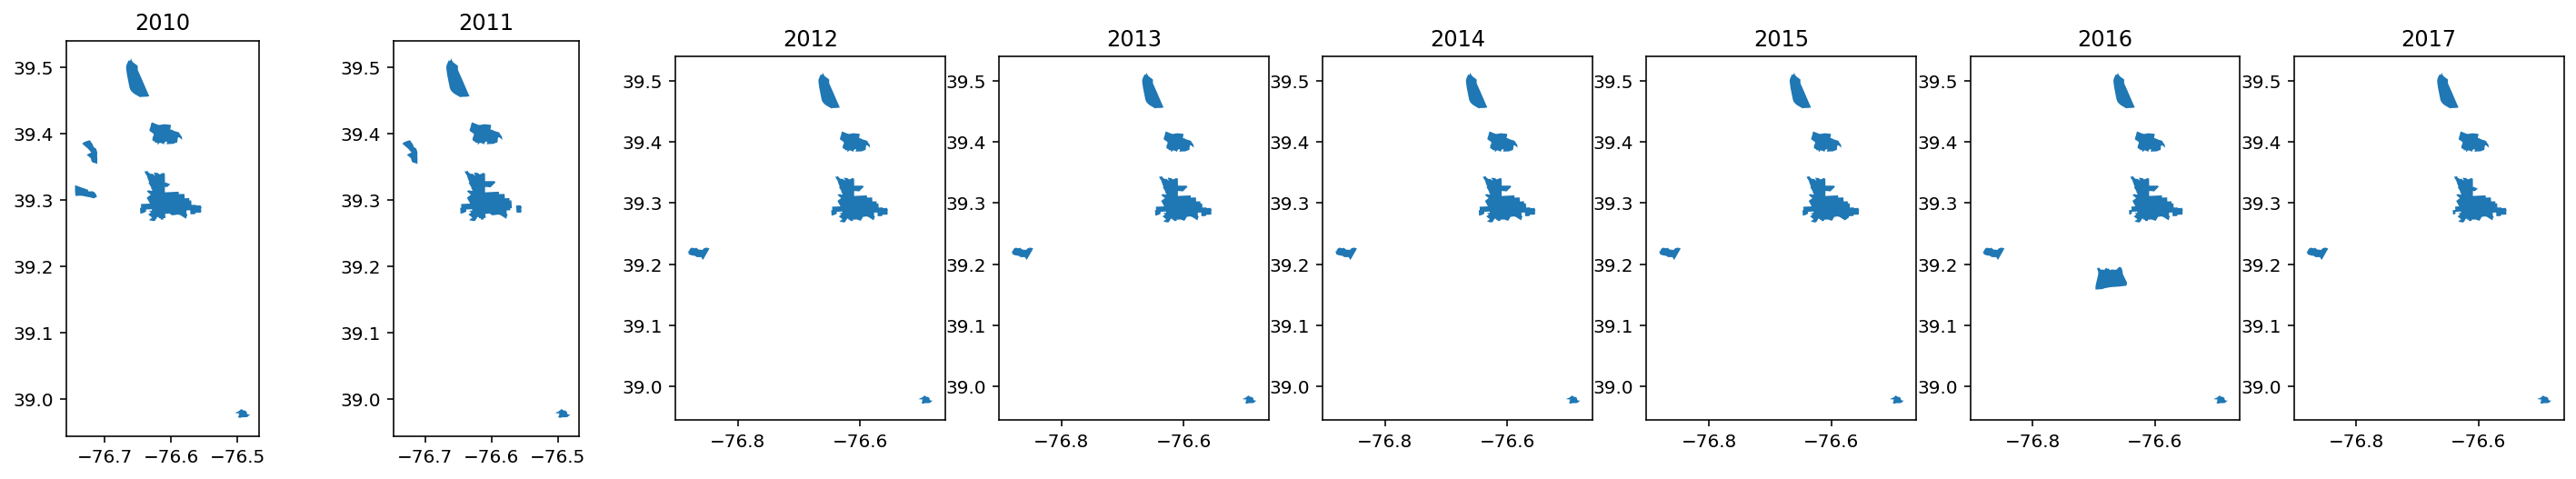

In [25]:
fig, ax = plt.subplots(1,8, figsize=(25,4))
for i, year in enumerate(gdf.year.sort_values().unique().astype(str)):
    
    df = to_center(tracts, year, 8000)
    
    df.plot(ax=ax[i])
    ax[i].set_title(year)


/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 28, 46.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 28, 46.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/ipykernel_launcher.py:6:

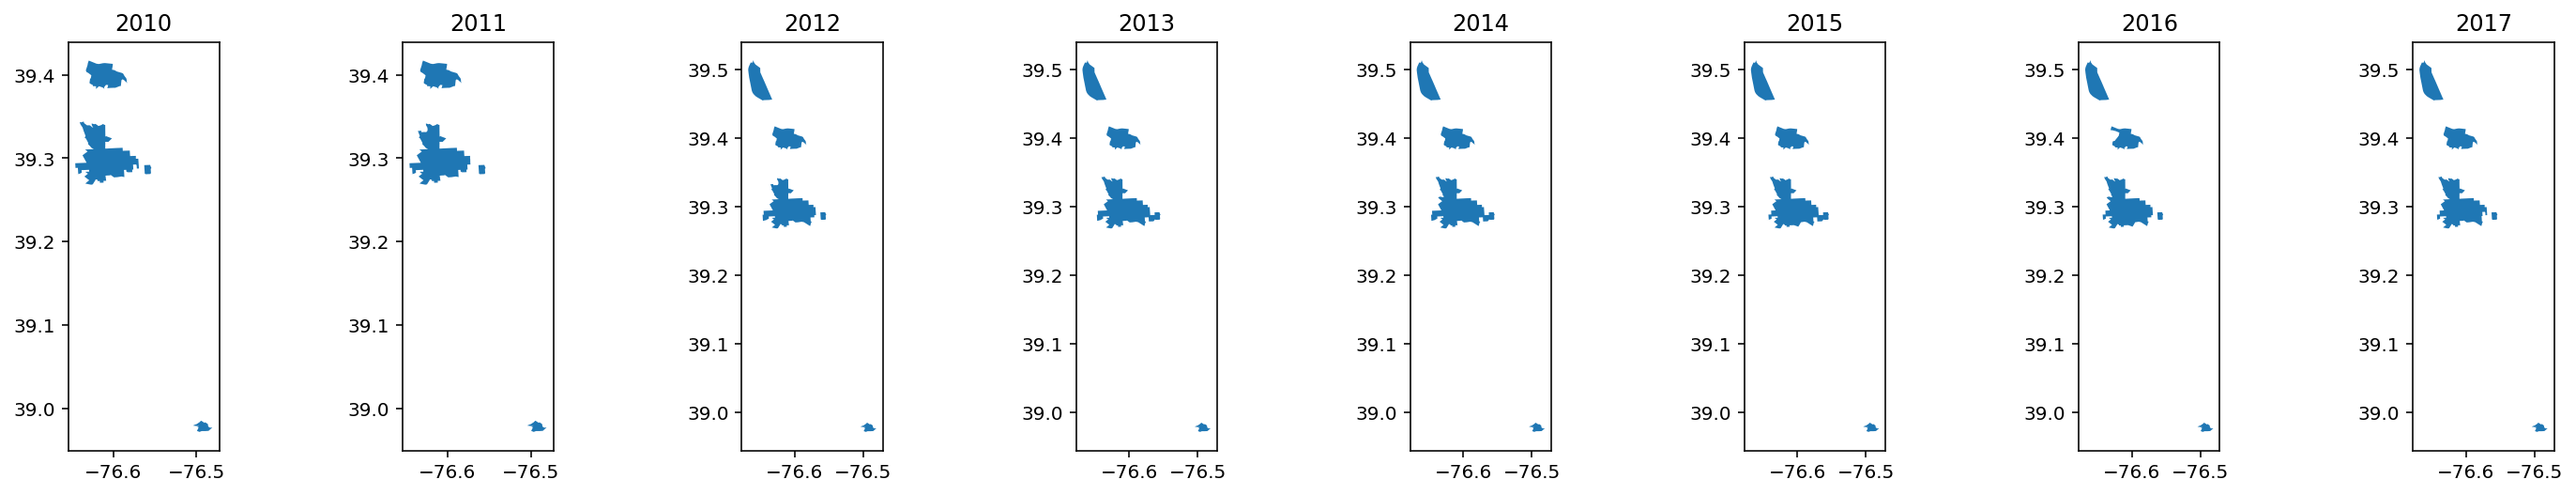

In [26]:
fig, ax = plt.subplots(1,8, figsize=(25,4))
for i, year in enumerate(gdf.year.sort_values().unique().astype(str)):
    
    df = to_center(tracts, year, 9000)
    
    df.plot(ax=ax[i])
    ax[i].set_title(year)


/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 7 islands with ids: 23, 41, 42, 66, 69, 76, 77.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 6 islands with ids: 24, 40, 41, 70, 78, 79.
  warnings.warn(message)
/Users/knaaptime/anaconda3/envs/maxp_emp/lib/python3.7/s

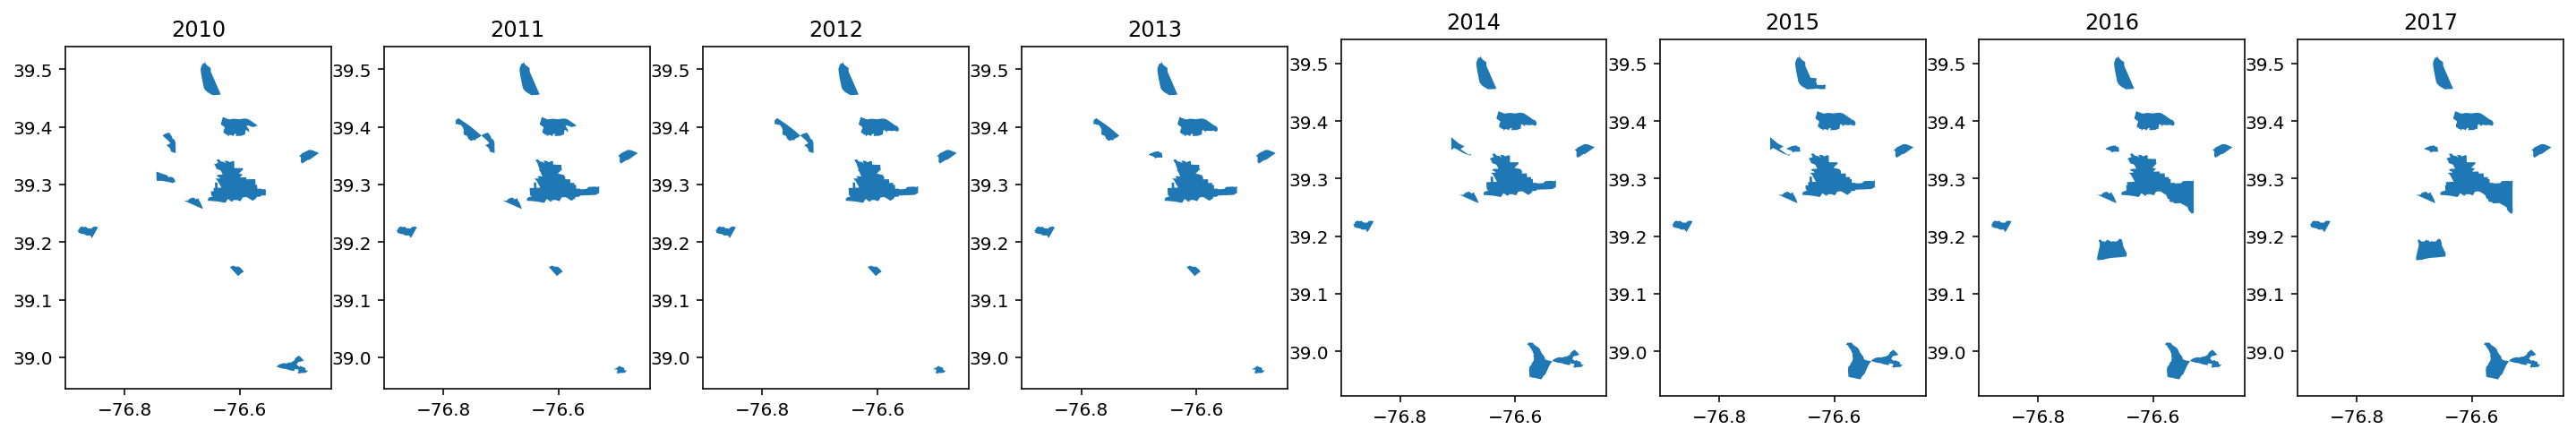

In [27]:
fig, ax = plt.subplots(1,8, figsize=(25,4))
for i, year in enumerate(gdf.year.sort_values().unique().astype(str)):
    
    df = to_center(tracts, year, 6000)
    
    df.plot(ax=ax[i])
    ax[i].set_title(year)


The results have some interesting variation; note that we're only changing the total employment cutoff here, not the bandwidth of the kernel, which gives us another parameter to play with. A handful of the centers are pretty robust over time (downtown balt in the center, annopolis home of the state government in the bottom right, linthicum in the center north). Others like fort meade (center left, just below downtown) appear and disappear with annual fluctuation